<a href="https://colab.research.google.com/github/pati-dev/text-multi-label/blob/master/attributes_from_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Boot

In [2]:
%load_ext tensorboard
%matplotlib inline
%tensorflow_version 2.x
import re
import pandas as pd
import numpy as np
import math

import tensorflow as tf
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
matplotlib.rc('axes',edgecolor='w')

TensorFlow 2.x selected.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Data Pre-processing

Load data

In [31]:
bizDF = pd.read_csv("/content/drive/My Drive/Search Project/toronto_filtered_reviews_all_cat.csv", encoding='utf8')
bizDF.head()

,Unnamed: 0,business_id,categories,user_id,text,RestaurantsPriceRange2,BikeParking,Parking.Garage,Parking.Street,Parking.Validated,Parking.Lot,Parking.Valet,RestaurantsTakeOut,GoodForKids,OutdoorSeating,RestaurantsGoodForGroups,RestaurantsReservations,RestaurantsDelivery,WiFi
0,1,c35qzLN6ItDpVIoj2uQW4Q,"Soup, Restaurants, Sandwiches",oAINPedtuyRWpeY7Ey-9Bg,"Very simple, yet very tasty wraps. Corn chow...",2,True,0,1,0,0,0,True,True,True,True,False,True,u'free'
1,2,c35qzLN6ItDpVIoj2uQW4Q,"Soup, Restaurants, Sandwiches",h9y55WNNg7SYg3kQwzTMmQ,"Had the soup and sandwich. Wow, it was great....",2,True,0,1,0,0,0,True,True,True,True,False,True,u'free'
2,3,c35qzLN6ItDpVIoj2uQW4Q,"Soup, Restaurants, Sandwiches",QfCfgc5PyNVwd_DgPzmeuA,I can't remember when I had a lunch as good as...,2,True,0,1,0,0,0,True,True,True,True,False,True,u'free'
3,4,c35qzLN6ItDpVIoj2uQW4Q,"Soup, Restaurants, Sandwiches",mKemb3MpSyUbsVUVSmI5tg,wow! the wraps are hearty and healthy. i had t...,2,True,0,1,0,0,0,True,True,True,True,False,True,u'free'
4,5,c35qzLN6ItDpVIoj2uQW4Q,"Soup, Restaurants, Sandwiches",zbSBmoujGgIPuNWQcny14g,First time here today w/ a male friend who had...,2,True,0,1,0,0,0,True,True,True,True,False,True,u'free'


In [32]:
bizDF.columns

Index(['Unnamed: 0', 'business_id', 'categories', 'user_id', 'text',
       'RestaurantsPriceRange2', 'BikeParking', 'Parking.Garage',
       'Parking.Street', 'Parking.Validated', 'Parking.Lot', 'Parking.Valet',
       'RestaurantsTakeOut', 'GoodForKids', 'OutdoorSeating',
       'RestaurantsGoodForGroups', 'RestaurantsReservations',
       'RestaurantsDelivery', 'WiFi'],
      dtype='object')

We have multiple rows for each *business* $\times$ *user* combination. Let's transform it so that it is in desired shape and form.

In [33]:
print(len(bizDF.business_id.unique()))
print(len(bizDF))
print(len(bizDF.text.unique()))

1880
167177
166910


Merge all reviews for a restaurant separated by a *space* in a separate reviews DF.

In [34]:
def combineText(reviews):
  return " ".join(reviews)

reviewsDF = pd.DataFrame(bizDF.groupby(['business_id'])['text'].apply(combineText).reset_index())
print(reviewsDF.head())
print(len(reviewsDF))

              business_id                                               text
0  -7BCZH437U5FjmNJ26llkg  This is a nice destination especially for thos...
1  -9u2uFwhlj3Yq4mG5IweoA  I'm not sure what to think of this place...hip...
2  -BbnAc9YEO6pjvJGEtFbVQ  Lovely little place for ramen amongst the many...
3  -CLTZ0cO-ooKDDmXHFoGMg  This was a planned visit as we were visiting a...
4  -EX_qttyhm5YNb8NWtAcCQ  Fun little bar for some country music!!! I wou...
1880


Merge reviews DF with shrunk down version of biz DF to get the final DF.

In [0]:
attribs = set(['BikeParking',
            # 'RestaurantsPriceRange2',
            'RestaurantsTakeOut',
            'GoodForKids', 
            'OutdoorSeating', 
            'RestaurantsGoodForGroups',
            'RestaurantsReservations', 
            'RestaurantsDelivery', 
            'WiFi'])

In [36]:
featuresDF = bizDF.loc[:, list(attribs) + ['business_id']].drop_duplicates()
finalDF = reviewsDF.merge(featuresDF, on='business_id')
print(finalDF.shape)
finalDF.head()

(1880, 10)


,business_id,text,BikeParking,RestaurantsTakeOut,RestaurantsGoodForGroups,RestaurantsReservations,WiFi,GoodForKids,RestaurantsDelivery,OutdoorSeating
0,-7BCZH437U5FjmNJ26llkg,This is a nice destination especially for thos...,True,True,True,True,'free',True,True,False
1,-9u2uFwhlj3Yq4mG5IweoA,I'm not sure what to think of this place...hip...,True,True,False,True,u'no',False,True,False
2,-BbnAc9YEO6pjvJGEtFbVQ,Lovely little place for ramen amongst the many...,True,True,True,False,'no',True,False,False
3,-CLTZ0cO-ooKDDmXHFoGMg,This was a planned visit as we were visiting a...,True,True,False,False,u'no',True,True,False
4,-EX_qttyhm5YNb8NWtAcCQ,Fun little bar for some country music!!! I wou...,True,True,True,False,u'no',False,False,False


# Data Cleaning

In [37]:
finalDF.dtypes

business_id                 object
text                        object
BikeParking                   bool
RestaurantsTakeOut            bool
RestaurantsGoodForGroups      bool
RestaurantsReservations       bool
WiFi                        object
GoodForKids                   bool
RestaurantsDelivery           bool
OutdoorSeating                bool
dtype: object

WiFi is a text variable with 'free', 'paid', or 'no' values. Let's convert it to boolean so that it's easier to deal with.

In [38]:
finalDF['Wifi'] = np.where( finalDF['WiFi'].str.contains('free') | finalDF['WiFi'].str.contains('paid'), True, False )
finalDF.loc[:,['WiFi', 'Wifi']].drop_duplicates()

,WiFi,Wifi
0,'free',True
1,u'no',False
2,'no',False
5,u'free',True
226,u'paid',True


In [39]:
finalDF = finalDF.drop('WiFi', axis=1)
finalDF.dtypes

business_id                 object
text                        object
BikeParking                   bool
RestaurantsTakeOut            bool
RestaurantsGoodForGroups      bool
RestaurantsReservations       bool
GoodForKids                   bool
RestaurantsDelivery           bool
OutdoorSeating                bool
Wifi                          bool
dtype: object

Number of characters in reviews is quite heavily right-tailed (left-skewed).

In [40]:
print('Number of missing reviews in review text:')
finalDF['text'].isnull().sum()

Number of missing reviews in review text:


0

In [41]:
reviewLen = finalDF.text.str.len()
reviewLen.describe()

count      1880.000000
mean      68465.901596
std       69833.415924
min        7668.000000
25%       29421.750000
50%       45682.500000
75%       80226.000000
max      847618.000000
Name: text, dtype: float64

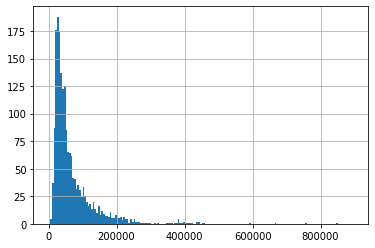

In [42]:
reviewLen.hist(bins = np.arange(0,900000,5000))

Clean reviews by clipping the text at first $100$K characters.

In [43]:
print(finalDF['text'][0])

This is a nice destination especially for those who prefer the all "halal" food. A nicely crafted pies Turkish style with delicious ingredients like the pastrami and the Turkish sausage. With options for vegetarians too.
It's very affordable and the service is ok. All I can say is that the staff are über friendly and the portions are massive! I had to take the rest home.  Pretty cheap if you can get two meals lol

Will be back 100% I really enjoyed the pizzas I ordered here.

They are done Turkish style with the pizza in a teardrop shape.

The pizzas I had were great with toppings I don't see often (lamb anyone?) and the fact that the pizza box was stuffed with lemon slices and tomato slices and onion slices and hot peppers, geesh, makes me want to go order one right now! Mr pide has the original Turkish pide just like you would have in Turkey. 
The flavours are authentic, the pide is made on the spot with fresh ground beef and other ingredients. 
Bottom line it's simple yet authentic.

In [44]:
def cleanTxt(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"it's", "it is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

finalDF['text'] = finalDF['text'].map(lambda review : cleanTxt(review[:100000]))
finalDF['text'][0]

'this is a nice destination especially for those who prefer the all halal food a nicely crafted pies turkish style with delicious ingredients like the pastrami and the turkish sausage with options for vegetarians too it is very affordable and the service is ok all i can say is that the staff are über friendly and the portions are massive i had to take the rest home pretty cheap if you can get two meals lol will be back 100 i really enjoyed the pizzas i ordered here they are done turkish style with the pizza in a teardrop shape the pizzas i had were great with toppings i do not see often lamb anyone and the fact that the pizza box was stuffed with lemon slices and tomato slices and onion slices and hot peppers geesh makes me want to go order one right now mr pide has the original turkish pide just like you would have in turkey the flavours are authentic the pide is made on the spot with fresh ground beef and other ingredients bottom line it is simple yet authentic great for a snack or l

In [0]:
finalDF.to_csv('/content/drive/My Drive/Search Project/finalDF.csv', index=False)

# Exploratory Analysis

The number of reviews per attribute are uneven. Since this is a multi-label problem and not a multi-class problem, we can't even them out due to potential data loss.



In [7]:
finalDF.rename({'Wifi' : 'WiFi'}, axis=1, inplace=True)
counts = []
for attrib in attribs:
    counts.append((attrib, finalDF[attrib].sum()))
statsDF = pd.DataFrame(counts, columns=['attribute', 'review_count'])
statsDF

,attribute,review_count
0,OutdoorSeating,749
1,RestaurantsDelivery,518
2,GoodForKids,1353
3,RestaurantsTakeOut,1672
4,WiFi,845
5,RestaurantsGoodForGroups,1606
6,RestaurantsReservations,1190
7,BikeParking,1680


Text(0.5, 0, 'Attribute')

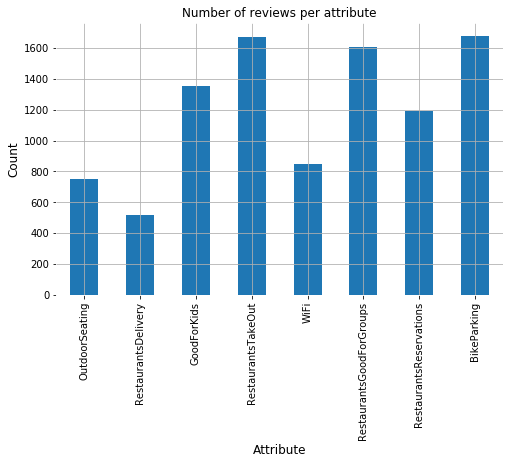

In [16]:
statsDF.plot(x='attribute', y='review_count', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of reviews per attribute")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Attribute', fontsize=12)

Distribution of attributes being **TRUE** very closely follows the bell curve with most businesses having $5$ attributes.

In [48]:
groupedDF = finalDF.iloc[:,2:].sum(axis=1)
attribCounts = groupedDF.value_counts()
attribCounts

5    486
6    465
4    385
7    253
3    178
8     55
2     50
1      8
dtype: int64

Text(0.5, 0, '# of attributes')

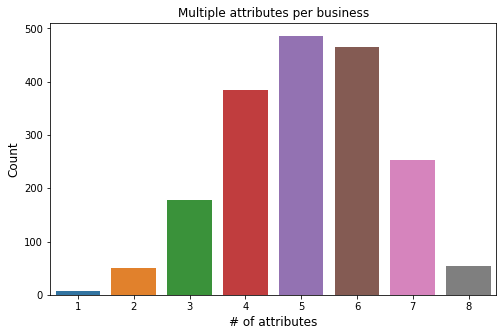

In [49]:
plt.figure(figsize=(8,5))
ax = sns.barplot(attribCounts.index, attribCounts.values)
plt.title("Multiple attributes per business")
plt.ylabel('Count', fontsize=12)
plt.xlabel('# of attributes', fontsize=12)

# Modeling

In [0]:
finalDF = pd.read_csv('/content/drive/My Drive/Search Project/finalDF.csv')

Vectorize review text.

In [0]:
num_words = 5000
seq_len = 180

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(finalDF.text)
sequences = tokenizer.texts_to_sequences(finalDF.text)
x = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=seq_len)

In [10]:
y = np.array(finalDF.iloc[:,2:])

print(x.shape)
print(y.shape)

(1880, 180)
(1880, 8)


In [0]:
y = y.astype('float32')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=6969)

In [0]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Embedding(input_dim=5000, 
                                    output_dim=20, 
                                    input_length=seq_len,
                                    dtype='float32'))
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.LSTM(units=8))

# model.add(tf.keras.layers.Conv1D(filters=32, 
#                                  kernel_size=2,
#                                  strides=1,
#                                  activation='relu'))
# model.add(tf.keras.layers.BatchNormalization())

# model.add(tf.keras.layers.Flatten())

# model.add(tf.keras.layers.Dense(units=1024, 
#                                activation='relu'))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dropout(0.1))

# model.add(tf.keras.layers.Dense(units=512, 
#                                activation='relu'))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Dense(units=y_train.shape[1], 
                               activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

def train_step(features, labels):
  with tf.GradientTape() as tape:
    logits = model(features, training=True)
    loss_value = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits)

  grads = tape.gradient(loss_value, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

def train(epochs, batchSize):
  for epoch in range(epochs):
    numBatches = math.ceil(x_train.shape[0] / batchSize)
    for batch in range(numBatches):
      start = batch*batchSize
      end = (batch+1)*batchSize
      features, labels = x_train[start:end], y_train[start:end]
      train_step(features, labels)
    print ('Epoch {} finished'.format(epoch+1))

In [37]:
train(20, 100)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 5 finished
Epoch 6 finished
Epoch 7 finished
Epoch 8 finished
Epoch 9 finished
Epoch 10 finished
Epoch 11 finished
Epoch 12 finished
Epoch 13 finished
Epoch 14 finished
Epoch 15 finished
Epoch 16 finished
Epoch 17 finished
Epoch 18 finished
Epoch 19 finished


In [66]:
trainPred = model.predict(x_train)
trainPred[:5]

array([[0.5773951 , 0.5388468 , 0.5847372 , 0.4721925 , 0.58725137,
        0.4016762 , 0.3328173 , 0.49977604],
       [0.58222413, 0.5455764 , 0.59218794, 0.4723752 , 0.5934583 ,
        0.39818874, 0.31798452, 0.49889666],
       [0.58501804, 0.54673785, 0.5992016 , 0.47093526, 0.60069466,
        0.3930898 , 0.30866188, 0.50371057],
       [0.58202344, 0.54743874, 0.5991206 , 0.4711505 , 0.5972563 ,
        0.39579803, 0.31327364, 0.4990319 ],
       [0.5734107 , 0.54875803, 0.5981697 , 0.4731431 , 0.59021527,
        0.40433186, 0.32295412, 0.49473056]], dtype=float32)

In [56]:
metrics = model.evaluate(x_test, y_test)
print('test loss, test acc:', metrics)

564/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [57]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/My Drive/Search Project/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/My Drive/Search Project/model.h5")
print("Saved model to disk")

Saved model to disk
